<a href="https://colab.research.google.com/github/LEANHDUC2005/Neural-Network---ANN/blob/main/CNN_TTS!!!.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import tarfile
import urllib.request

# Đường dẫn lưu dữ liệu
data_dir = "/content/drive/MyDrive/TTS_Project/data"
os.makedirs(data_dir, exist_ok=True)

# URL của bộ dữ liệu LJSpeech-1.1
url = "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"
filename = os.path.join(data_dir, "LJSpeech-1.1.tar.bz2")

# Tải dữ liệu nếu chưa có
if not os.path.exists(filename):
    print("Đang tải LJSpeech-1.1...")
    urllib.request.urlretrieve(url, filename)
    print("Tải xong.")

# Giải nén dữ liệu
extract_path = os.path.join(data_dir, "LJSpeech-1.1")
if not os.path.exists(extract_path):
    print("Đang giải nén dữ liệu...")
    with tarfile.open(filename, "r:bz2") as tar:
        tar.extractall(path=data_dir)
    print("Giải nén xong.")
else:
    print("Dữ liệu đã được giải nén.")


Đang tải LJSpeech-1.1...
Tải xong.
Đang giải nén dữ liệu...
Giải nén xong.


In [2]:
import pandas as pd

# Đường dẫn đến file metadata
metadata_path = os.path.join(extract_path, "metadata.csv")

# Đọc metadata
metadata = pd.read_csv(metadata_path, sep="|", header=None, names=["id", "text", "normalized_text"])

# Thêm cột đường dẫn đến file âm thanh
metadata["audio_path"] = metadata["id"].apply(lambda x: os.path.join(extract_path, "wavs", f"{x}.wav"))

# Hiển thị 5 dòng đầu tiên
metadata.head()


,id,text,normalized_text,audio_path
0,LJ001-0001,"Printing, in the only sense with which we are ...","Printing, in the only sense with which we are ...",/content/drive/MyDrive/TTS_Project/data/LJSpee...
1,LJ001-0002,in being comparatively modern.,in being comparatively modern.,/content/drive/MyDrive/TTS_Project/data/LJSpee...
2,LJ001-0003,For although the Chinese took impressions from...,For although the Chinese took impressions from...,/content/drive/MyDrive/TTS_Project/data/LJSpee...
3,LJ001-0004,"produced the block books, which were the immed...","produced the block books, which were the immed...",/content/drive/MyDrive/TTS_Project/data/LJSpee...
4,LJ001-0005,the invention of movable metal letters in the ...,the invention of movable metal letters in the ...,/content/drive/MyDrive/TTS_Project/data/LJSpee...


In [39]:
import re

def normalize_text(text):
    # Convert to string to handle potential float values
    text = str(text)
    text = text.lower()
    text = re.sub(r"[^a-z.,!?'\s]", "", text)  # Chỉ giữ lại ký tự a-z và một số dấu cơ bản
    text = re.sub(r"\s+", " ", text).strip()  # Bỏ khoảng trắng thừa
    return text

metadata["normalized_text"] = metadata["normalized_text"].apply(normalize_text)
metadata.head()

from sklearn.model_selection import train_test_split

# Chia tập train + val trước
train_val, test = train_test_split(metadata, test_size=0.2, random_state=42)
train, val = train_test_split(train_val, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

print(f"Số lượng mẫu:")
print(f"Train: {len(train)}, Val: {len(val)}, Test: {len(test)}")
output_dir = os.path.join(data_dir, "splits")
os.makedirs(output_dir, exist_ok=True)

train.to_csv(os.path.join(output_dir, "train.csv"), index=False)
val.to_csv(os.path.join(output_dir, "val.csv"), index=False)
test.to_csv(os.path.join(output_dir, "test.csv"), index=False)

# ---The fix---
# Recreate train_files and val_files from your DataFrames to ensure that they reference the DataFrames
train_files = list(zip(train["audio_path"], train["normalized_text"])) # Create list of (audio_path, text) tuples for training
val_files = list(zip(val["audio_path"], val["normalized_text"]))   # Create list of (audio_path, text) tuples for validation


Số lượng mẫu:
Train: 7860, Val: 2620, Test: 2620


In [44]:
import torch
import torch.nn as nn

class CNNTTS(nn.Module):
    def __init__(self, vocab_size=70, embed_dim=128):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(embed_dim, 256, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Conv1d(256, 512, kernel_size=5, padding=2),
            nn.ReLU(),
        )

        # Decoder (simple upsample + conv transpose)
        # Adjust padding to match output shape
        # Changed stride to 1 and added padding
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(512, 80, kernel_size=5, stride=2, padding=2),
            nn.Tanh()  # Add a Tanh activation to restrict output range
        )

        # PostNet (refine mel)
        self.postnet = nn.Sequential(
            nn.Conv1d(80, 512, kernel_size=5, padding=2),
            nn.Tanh(),
            nn.Conv1d(512, 80, kernel_size=5, padding=2),
            )
    def forward(self, x, target_len=None):  # Add target_len argument
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = self.encoder(x)
        mel = self.decoder(x)

        # Calculate padding to match target length ONLY IF target_len is provided
        if target_len is not None: # Use target_len if provided
            max_mel_len = target_len
            padding_size = max_mel_len - mel.shape[2]

            # Apply padding if necessary
            if padding_size > 0:
                padding = torch.zeros(mel.shape[0], mel.shape[1], padding_size, device=mel.device)  # Zeros padding
                mel = torch.cat([mel, padding], dim=2)
            elif padding_size < 0:
                mel = mel[:, :, :max_mel_len]  # Truncate if output is longer
        # Otherwise, NO padding adjustment is performed

        mel_post = mel + self.postnet(mel)
        return mel_post


import string

# Tạo bảng chữ cái
vocab = list(" " + string.ascii_lowercase + ".,!?'-")  # 1 space + 26 chữ cái + 6 dấu
char2id = {ch: i+1 for i, ch in enumerate(vocab)}  # Start from 1
char2id["<pad>"] = 0
id2char = {i: ch for ch, i in char2id.items()}

def text_to_sequence(text, char2id, max_len=200):
    ids = [char2id.get(ch, 0) for ch in text]  # default to <pad> if unknown
    if len(ids) < max_len:
        ids += [0] * (max_len - len(ids))  # pad
    return torch.tensor(ids[:max_len])



In [8]:
!pip install librosa

In [52]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
!pip install torchaudio # install torchaudio
import torchaudio
import librosa
import numpy as np

def extract_mel_spectrogram(wav_path, save_path):
    """
    Extracts mel spectrogram from a WAV file and saves it as an NPY file.

    Args:
        wav_path: Path to the WAV file.
        save_path: Path to save the mel spectrogram as an NPY file.
    """
    waveform, sample_rate = torchaudio.load(wav_path) # load waveform using torchaudio
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_mels=80 # Adjust n_mels as needed
    )(waveform).squeeze(0).numpy()

    # Apply min-max normalization
    min_val = mel_spectrogram.min()
    max_val = mel_spectrogram.max()
    normalized_mel_spectrogram = (mel_spectrogram - min_val) / (max_val - min_val)

    np.save(save_path, normalized_mel_spectrogram)

# Update your dataset class to perform the same normalization for target Mel Spectrograms:
class LJSpeechDataset(Dataset):
    def __init__(self, files, char2id, max_text_len=200):
        self.files = files
        self.char2id = char2id
        self.max_text_len = max_text_len

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        wav_path, text = self.files[idx]
        mel = np.load(wav_path.replace(".wav", ".npy"))  # Giả định đã chuẩn hóa

        # Apply min-max normalization if not already normalized
        min_val = mel.min()
        max_val = mel.max()
        if (max_val - min_val) > 0: # avoid division by zero
            mel = (mel - min_val) / (max_val - min_val)

        mel_tensor = torch.tensor(mel, dtype=torch.float32)  # (80, T)
        text_tensor = text_to_sequence(text.lower(), self.char2id, self.max_text_len)
        return text_tensor, mel_tensor
def collate_fn(batch):
    texts, mels = zip(*batch)
    max_text_len = max([t.size(0) for t in texts])
    max_mel_len = max([m.size(1) for m in mels])

    texts_padded = torch.stack([F.pad(t, (0, max_text_len - t.size(0))) for t in texts])

    # Pad mels to the maximum length
    mels_padded = torch.zeros(len(mels), mels[0].shape[0], max_mel_len) # Create a zero tensor with the desired shape
    for i, mel in enumerate(mels):
        mels_padded[i, :, :mel.shape[1]] = mel # Copy the mel spectrogram into the padded tensor


    return texts_padded, mels_padded

# Create train_files and val_files from your DataFrames

train_dataset = LJSpeechDataset(train_files, char2id)
val_dataset = LJSpeechDataset(val_files, char2id)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

import torch.optim as optim
from torch.nn import MSELoss
from torch.optim.lr_scheduler import ReduceLROnPlateau

model = CNNTTS(vocab_size=len(char2id)).cuda()
criterion = MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

def evaluate(model, loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.cuda(), y.cuda()

            #Get target_len from y
            target_len = y.shape[2]

            #Pass target_len to model.forward
            y_pred = model(x, target_len=target_len)

            loss = criterion(y_pred, y)
            total_loss += loss.item()
    return total_loss / len(loader)

def train(model, train_loader, val_loader, epochs):
    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0
        for x, y in train_loader:
            x, y = x.cuda(), y.cuda()

            # Get target_len from y for training as well
            target_len = y.shape[2]

            # Pass target_len to model.forward during training
            y_pred = model(x, target_len=target_len)

            loss = criterion(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        val_loss = evaluate(model, val_loader)

        scheduler.step(val_loss)

        print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        # Inside the training loop
        # After every training loss evaluation.

        scheduler.step(train_loss)  # Using training loss for scheduling

train(model, train_loader, val_loader, epochs=50)

torch.save(model.state_dict(), "cnntts_model.pth")
print("Mô hình đã được lưu vào: cnntts_model.pth")

model = CNNTTS(vocab_size=len(char2id)).cuda()
model.load_state_dict(torch.load("cnntts_model.pth"))
model.eval()


Epoch 1 | Train Loss: 0.0017 | Val Loss: 0.0006
Epoch 2 | Train Loss: 0.0004 | Val Loss: 0.0004
Epoch 3 | Train Loss: 0.0004 | Val Loss: 0.0003
Epoch 4 | Train Loss: 0.0004 | Val Loss: 0.0003
Epoch 5 | Train Loss: 0.0003 | Val Loss: 0.0003
Epoch 6 | Train Loss: 0.0283 | Val Loss: 0.0006
Epoch 7 | Train Loss: 0.0013 | Val Loss: 0.0010
Epoch 8 | Train Loss: 0.0024 | Val Loss: 0.0014
Epoch 9 | Train Loss: 0.0004 | Val Loss: 0.0004
Epoch 10 | Train Loss: 0.0006 | Val Loss: 0.0008
Epoch 11 | Train Loss: 0.0009 | Val Loss: 0.0012
Epoch 12 | Train Loss: 0.0004 | Val Loss: 0.0003
Epoch 13 | Train Loss: 0.0004 | Val Loss: 0.0004
Epoch 14 | Train Loss: 0.0005 | Val Loss: 0.0004
Epoch 15 | Train Loss: 0.0003 | Val Loss: 0.0003
Epoch 16 | Train Loss: 0.0004 | Val Loss: 0.0003
Epoch 17 | Train Loss: 0.0004 | Val Loss: 0.0004
Epoch 18 | Train Loss: 0.0003 | Val Loss: 0.0003
Epoch 19 | Train Loss: 0.0003 | Val Loss: 0.0003
Epoch 20 | Train Loss: 0.0003 | Val Loss: 0.0003
Epoch 21 | Train Loss: 0.0003

CNNTTS(
  (embedding): Embedding(34, 128)
  (encoder): Sequential(
    (0): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv1d(256, 512, kernel_size=(5,), stride=(1,), padding=(2,))
    (4): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(512, 80, kernel_size=(5,), stride=(2,), padding=(2,))
    (1): Tanh()
  )
  (postnet): Sequential(
    (0): Conv1d(80, 512, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): Tanh()
    (2): Conv1d(512, 80, kernel_size=(5,), stride=(1,), padding=(2,))
  )
)

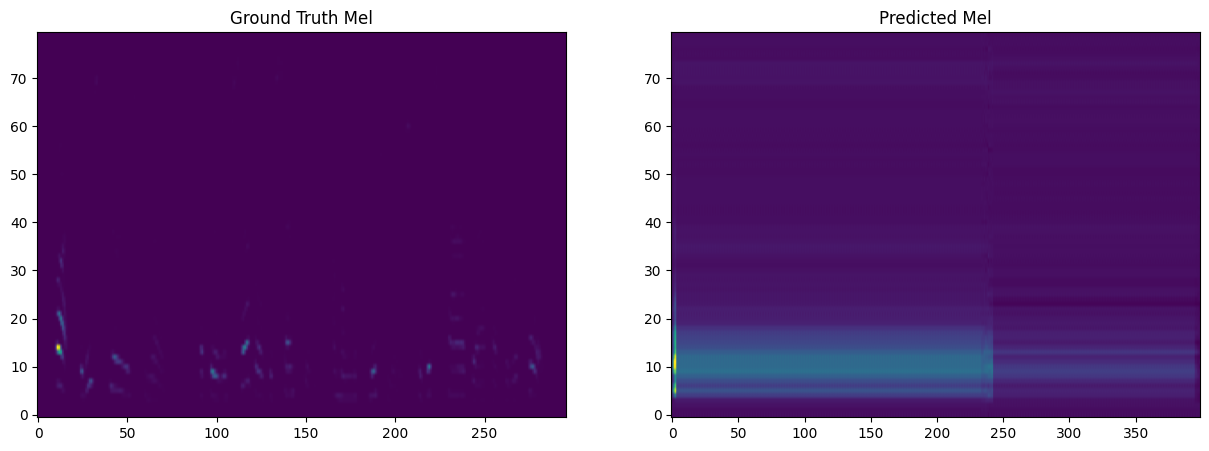

In [54]:
import matplotlib.pyplot as plt

x_sample, y_sample = val_dataset[0]
x_sample = x_sample.unsqueeze(0).cuda()  # (1, T)

with torch.no_grad():
    y_pred = model(x_sample)  # (1, 80, T)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title("Ground Truth Mel")
plt.imshow(y_sample.numpy(), aspect="auto", origin="lower")

plt.subplot(1, 2, 2)
plt.title("Predicted Mel")
plt.imshow(y_pred.squeeze(0).cpu().numpy(), aspect="auto", origin="lower")
plt.show()


In [90]:
import torch

# Load pretrained MelGAN từ torch.hub
melgan = torch.hub.load('seungwonpark/melgan', 'melgan')
melgan.eval()


Using cache found in /root/.cache/torch/hub/seungwonpark_melgan_master
/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


In [60]:
import pandas as pd

# Instead of reading from 'test.csv', save the DataFrame 'test' to a CSV file
test.to_csv("test.csv", index=False)  # This creates the file

# Now you can read it back in
df_test = pd.read_csv("test.csv")  # Should work without error

print(f"📄 Tổng số mẫu test: {len(df_test)}")

📄 Tổng số mẫu test: 2620


In [96]:
import torch
import torchaudio
import os
import numpy as np
import pandas as pd  # Import pandas để đọc file CSV
import torchaudio.transforms as T  # Import torchaudio transforms

# Đảm bảo thư mục đầu ra tồn tại
os.makedirs("tts_eval_outputs", exist_ok=True)

# Hàm tổng hợp âm thanh từ văn bản (sử dụng mô hình TTS và vocoder MelGAN)
def synthesize_sample(text, idx, tts_model, vocoder_model, char2id, save_dir="tts_eval_outputs"):
    # Chuyển văn bản thành chuỗi ID sử dụng char2id
    text_tensor = text_to_sequence(text.lower(), char2id, max_len=200).unsqueeze(0).cuda()  # Unsqueeze và chuyển sang CUDA

    # Pass text_tensor vào mô hình
    with torch.no_grad():
        mel = tts_model(text_tensor)  # Giả sử tts_model có phương thức forward() hoặc predict()

    # Chuyển đổi mel spectrogram thành audio waveform sử dụng vocoder
    audio = mel_to_audio(mel.cpu().squeeze(0))  # Di chuyển mel về CPU và bỏ batch dimension

    # Lưu waveform audio vào file
    save_path = os.path.join(save_dir, f"{idx}.wav")
    torchaudio.save(save_path, audio, 22050)  # Giả sử sample rate là 22050

    return save_path  # Trả về đường dẫn của file đã lưu

# Hàm chuyển đổi mel spectrogram thành audio
def mel_to_audio(mel_spec):
    """
    mel_spec: Tensor [80, T]
    Returns: audio waveform [T]
    """
    mel_spec = mel_spec.unsqueeze(0)  # Thêm batch dimension [1, 80, T]

    # Resample mel spectrogram to have the required number of Mel channels (usually 80 for MelGAN)
    resample = T.Resample(
        orig_freq=80,  # Original number of Mel channels (from your model)
        new_freq=80,  # MelGAN vocoder expects 80 Mel channels
    )
    mel_spec = resample(mel_spec)  # Apply resampling

    # Adjust the zero tensor to match the mel_spec's time dimension:
    zero = torch.full((1, mel_spec.shape[1], 10), -11.5129).to(mel_spec.device)
    mel_spec = torch.cat((mel_spec, zero), dim=2)

    mel_spec = mel_spec.transpose(1, 2)  # Chuyển đổi thành [1, T, 80]
    with torch.no_grad():
        audio = melgan_vocoder.inference(mel_spec).squeeze(0)  # Bỏ batch dimension
    return audio

# Đảm bảo rằng bạn đã tải model MelGAN trước đó
melgan_vocoder = melgan  # Giả sử melgan là vocoder đã được tải

# Đọc dữ liệu từ file CSV (ví dụ test.csv)
df_test = pd.read_csv("test.csv")  # Thay đổi đường dẫn đến file test.csv của bạn

gen_paths = []
for i, row in df_test.iterrows():
    text = row["text"]  # Văn bản từ file CSV
    gen_path = synthesize_sample(text, i, model, melgan_vocoder, char2id)  # Pass char2id vào hàm synthesize_sample
    gen_paths.append(gen_path)

# In ra đường dẫn các file .wav đã được tạo
for path in gen_paths[:5]:  # In đường dẫn của 5 file đầu tiên
    print(f"Generated file: {path}")

RuntimeError: Sizes of tensors must match except in dimension 2. Expected size 409 but got size 80 for tensor number 1 in the list.